In [1]:
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
print(torch.__version__) # 1.0.1

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
2.0.0


In [49]:
class Discriminator(torch.nn.Module):
    def __init__(self, inp_dim=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = x.view(x.size(0), 784) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out

In [50]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 784)
    def forward(self, x):
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.tanh(out) # range [-1, 1]
        # convert to image 
        out = out.view(out.size(0), 1, 28, 28)
        return out

In [4]:
# instantiate a Generator and Discriminator according to their class definition.
D = Discriminator()
print(D)
G = Generator()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


In [5]:
# let's download the Fashion MNIST data, if you do this locally and you downloaded before,
# you can change data paths to point to your existing files
# dataset = torchvision.datasets.MNIST(root='./MNISTdata', ...)
dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST/',
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))]),
                       download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12456892.30it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211457.95it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3926722.09it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21965693.79it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



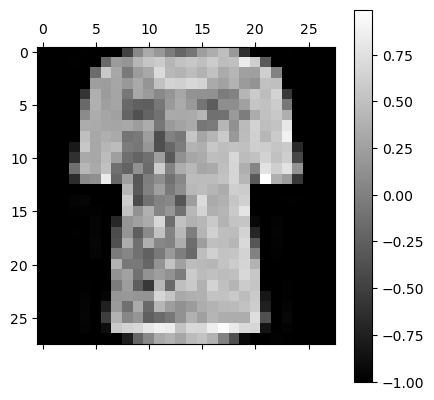

In [6]:
ix=149
x, _ = dataset[ix]
plt.matshow(x.squeeze().numpy(), cmap=plt.cm.gray)
plt.colorbar()

In [7]:
# and the BCE criterion which computes the loss above:
criterion = nn.BCELoss()

In [10]:
# Remember we have defined the discriminator and generator as:
D = Discriminator()
print(D)
G = Generator()
print(G)
# Now let's set up the optimizers
optimizerD = torch.optim.SGD(D.parameters(), lr=0.01)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.01)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


In [11]:
# STEP 1: Discriminator optimization step
x_real, _ = iter(dataloader).__next__()
lab_real = torch.ones(64, 1)
lab_fake = torch.zeros(64, 1)
# reset accumulated gradients from previous iteration
optimizerD.zero_grad()

D_x = D(x_real)
lossD_real = criterion(D_x, lab_real)

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
x_gen = G(z).detach()
D_G_z = D(x_gen)
lossD_fake = criterion(D_G_z, lab_fake)

lossD = lossD_real + lossD_fake
lossD.backward()
optimizerD.step()

# print(D_x.mean().item(), D_G_z.mean().item())

In [12]:
# STEP 2: Generator optimization step
# note how only one of the terms involves the Generator so this is the only one that matters for G.
# reset accumulated gradients from previous iteration
optimizerG.zero_grad()

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
D_G_z = D(G(z))
lossG = criterion(D_G_z, lab_real) # -log D(G(z))

lossG.backward()
optimizerG.step()

print(D_G_z.mean().item())

0.4789562225341797


In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
# Re-initialize D, G:
D = Discriminator().to(device)
G = Generator().to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
# optimizerD = torch.optim.Adam(D.parameters(), lr=0.001)
# optimizerG = torch.optim.Adam(G.parameters(), lr=0.001)
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)


# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, 100, device=device)
fig = plt.figure() # keep updating this one
plt.ion()

all_losses_D = []
all_losses_G = []
for epoch in range(10):  # 3 epochs
    size = 0
    current_loss = 0
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = iter(dataloader).__next__()
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)
        lossD = lossD_real + lossD_fake

        lossD.backward()
        optimizerD.step()

        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real)  # -log D(G(z))

        lossG.backward()
        optimizerG.step()
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            # show_imgs(x_gen, new_fig=False)
            fig.canvas.draw()
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()))

    all_losses_D.append(lossD.cpu().detach().numpy())
    all_losses_G.append(lossG.cpu().detach().numpy())
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

Device:  cuda
e0.i0/938 last mb D(x)=0.4893 D(G(z))=0.5044
e0.i100/938 last mb D(x)=0.9384 D(G(z))=0.3732
e0.i200/938 last mb D(x)=0.9442 D(G(z))=0.1613
e0.i300/938 last mb D(x)=0.8033 D(G(z))=0.2033
e0.i400/938 last mb D(x)=0.9093 D(G(z))=0.1146
e0.i500/938 last mb D(x)=0.5965 D(G(z))=0.4420
e0.i600/938 last mb D(x)=0.8420 D(G(z))=0.1513
e0.i700/938 last mb D(x)=0.5971 D(G(z))=0.5091
e0.i800/938 last mb D(x)=0.6880 D(G(z))=0.3806
e0.i900/938 last mb D(x)=0.5595 D(G(z))=0.3979
e1.i0/938 last mb D(x)=0.9580 D(G(z))=0.0673
e1.i100/938 last mb D(x)=0.7954 D(G(z))=0.2369
e1.i200/938 last mb D(x)=0.6572 D(G(z))=0.3306
e1.i300/938 last mb D(x)=0.6172 D(G(z))=0.4582
e1.i400/938 last mb D(x)=0.8134 D(G(z))=0.1747
e1.i500/938 last mb D(x)=0.9258 D(G(z))=0.0861
e1.i600/938 last mb D(x)=0.6164 D(G(z))=0.4770
e1.i700/938 last mb D(x)=0.6472 D(G(z))=0.3688
e1.i800/938 last mb D(x)=0.9144 D(G(z))=0.1110
e1.i900/938 last mb D(x)=0.9358 D(G(z))=0.0303
e2.i0/938 last mb D(x)=0.8946 D(G(z))=0.1042
e2.i1

<Figure size 640x480 with 0 Axes>

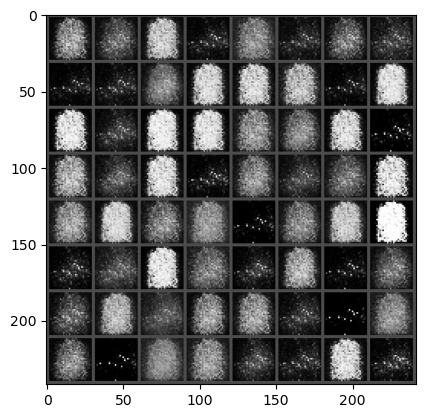

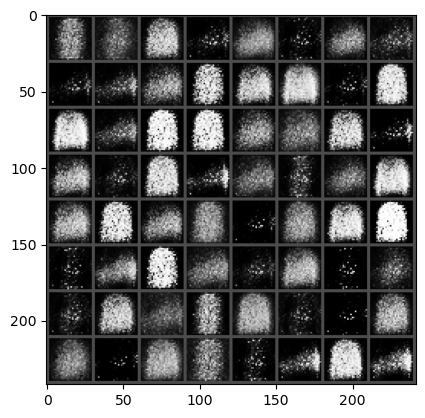

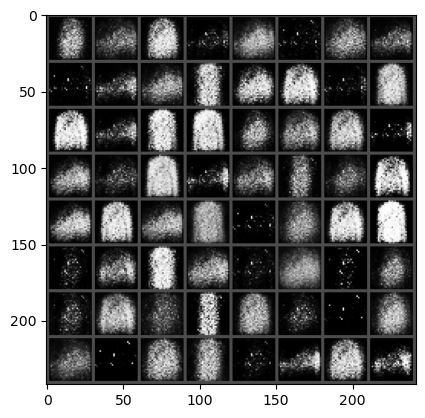

In [17]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

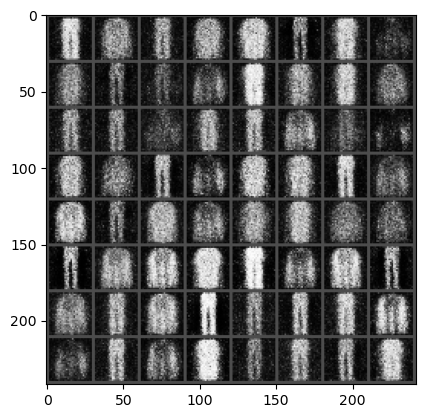

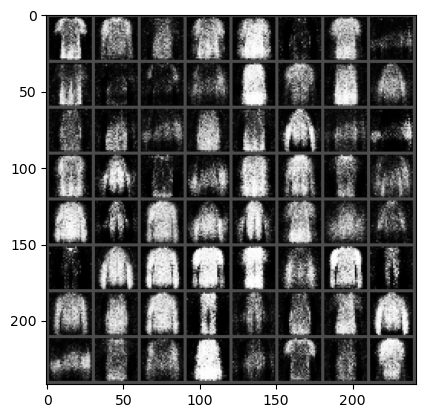

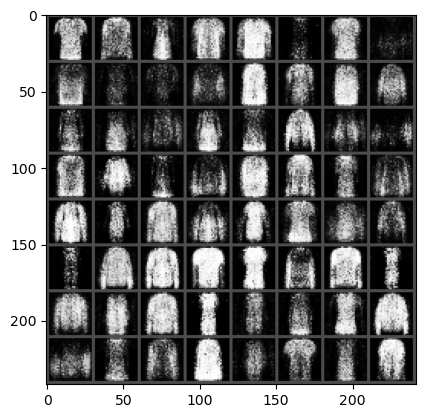

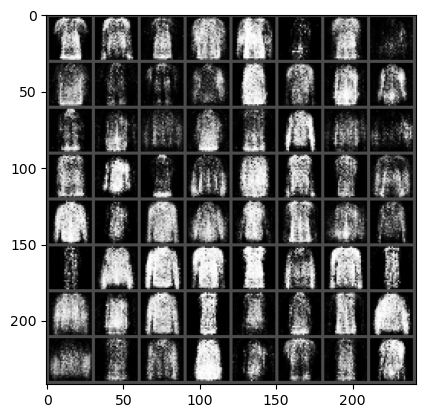

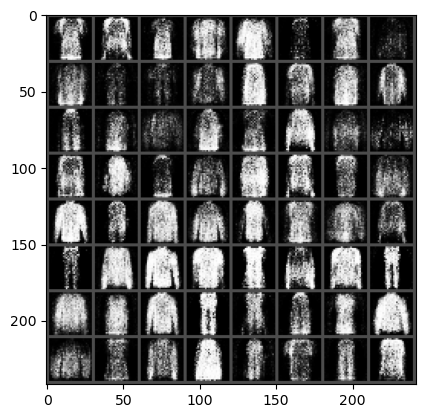

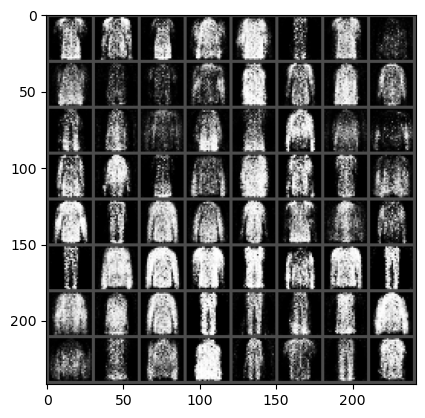

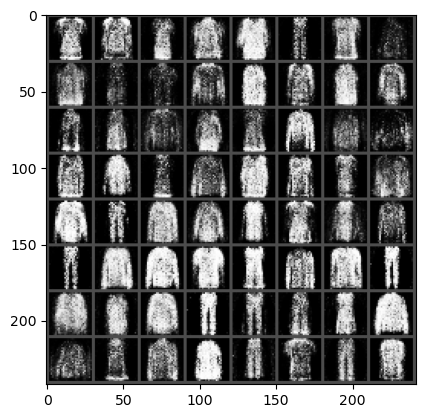

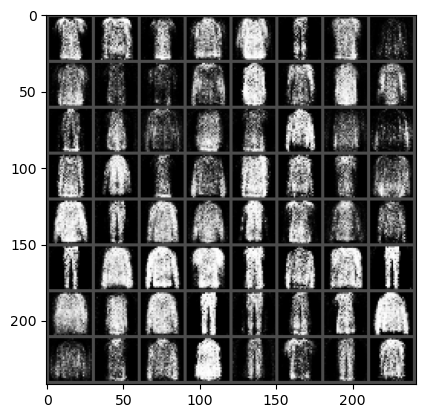

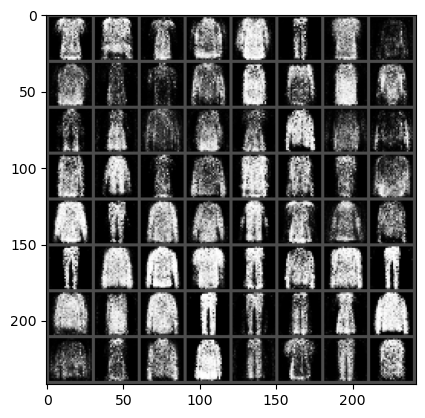

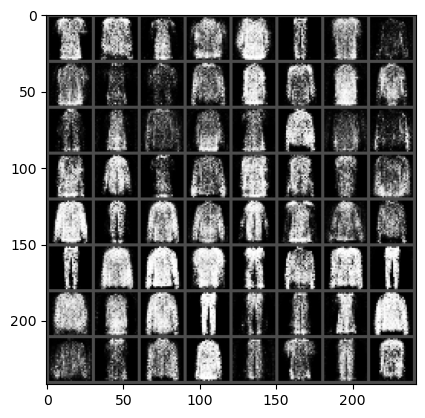

In [21]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

In [17]:
import numpy as np

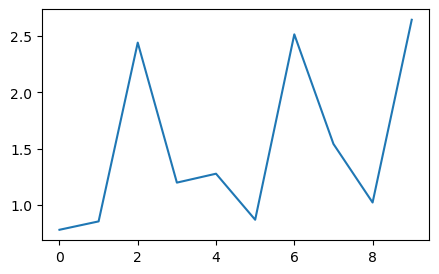

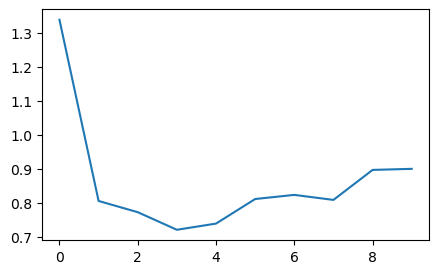

In [22]:
plt.figure(figsize=(5, 3))
plt.plot(all_losses_G)
plt.savefig('lossG')

plt.figure(figsize=(5, 3))
plt.plot(all_losses_D)
plt.savefig('lossV')

In [53]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
# Re-initialize D, G:
D = Discriminator().to(device)
G = Generator().to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
# optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
# optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
optimizerD = torch.optim.Adam(D.parameters(), lr=0.002)
optimizerG = torch.optim.Adam(G.parameters(), lr=0.002)
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)


# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, 100, device=device)
fig = plt.figure() # keep updating this one
plt.ion()

all_losses_D = []
all_losses_G = []
for epoch in range(3):  # 3 epochs
    size = 0
    current_loss = 0
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = iter(dataloader).__next__()
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)
        lossD = lossD_real + lossD_fake

        lossD.backward()
        optimizerD.step()

        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real)  # -log D(G(z))

        lossG.backward()
        optimizerG.step()
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            # show_imgs(x_gen, new_fig=False)
            fig.canvas.draw()
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()))

    all_losses_D.append(lossD.cpu().detach().numpy())
    all_losses_G.append(lossG.cpu().detach().numpy())
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

Device:  cuda
e0.i0/938 last mb D(x)=0.4892 D(G(z))=0.4593
e0.i100/938 last mb D(x)=0.9961 D(G(z))=0.0338
e0.i200/938 last mb D(x)=0.8348 D(G(z))=0.1418
e0.i300/938 last mb D(x)=0.7543 D(G(z))=0.1000
e0.i400/938 last mb D(x)=0.9162 D(G(z))=0.0108
e0.i500/938 last mb D(x)=0.9377 D(G(z))=0.0576
e0.i600/938 last mb D(x)=0.9565 D(G(z))=0.0831
e0.i700/938 last mb D(x)=0.7938 D(G(z))=0.0675
e0.i800/938 last mb D(x)=0.8844 D(G(z))=0.0518
e0.i900/938 last mb D(x)=0.7895 D(G(z))=0.1293
e1.i0/938 last mb D(x)=0.8859 D(G(z))=0.0714
e1.i100/938 last mb D(x)=0.9286 D(G(z))=0.0412
e1.i200/938 last mb D(x)=0.6827 D(G(z))=0.1334
e1.i300/938 last mb D(x)=0.8060 D(G(z))=0.2043
e1.i400/938 last mb D(x)=0.6082 D(G(z))=0.2347
e1.i500/938 last mb D(x)=0.8504 D(G(z))=0.0588
e1.i600/938 last mb D(x)=0.9364 D(G(z))=0.0823
e1.i700/938 last mb D(x)=0.8966 D(G(z))=0.0567
e1.i800/938 last mb D(x)=0.8946 D(G(z))=0.1472
e1.i900/938 last mb D(x)=0.7237 D(G(z))=0.1057
e2.i0/938 last mb D(x)=0.8414 D(G(z))=0.0712
e2.i1

<Figure size 640x480 with 0 Axes>

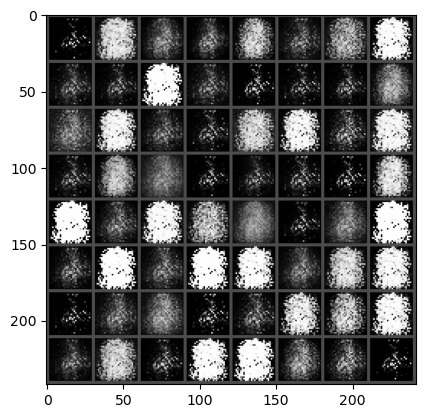

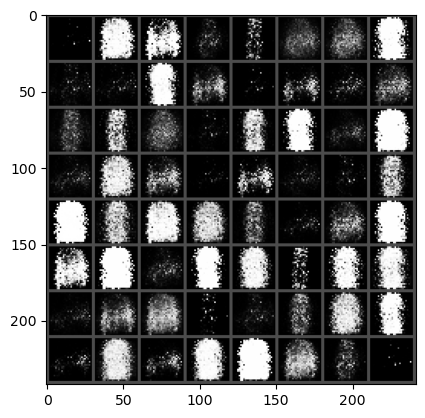

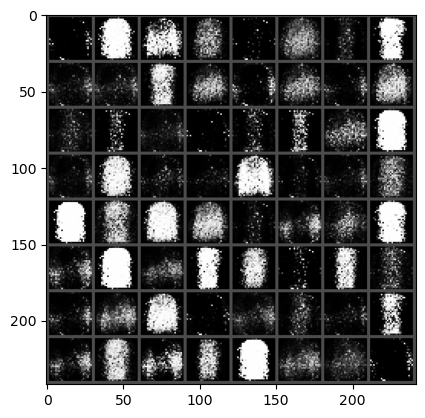

In [54]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)
    

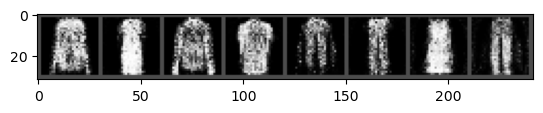

In [23]:
random_noise = torch.randn(8, 100, device=device)
x_gen = G(random_noise)
show_imgs(x_gen, new_fig=False)

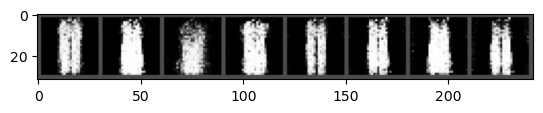

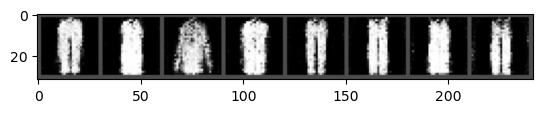

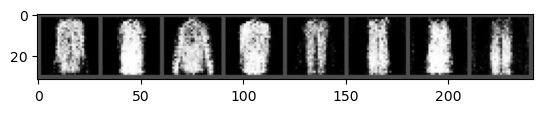

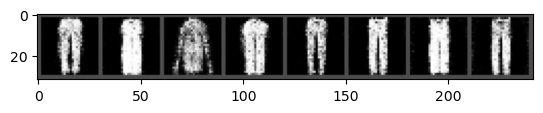

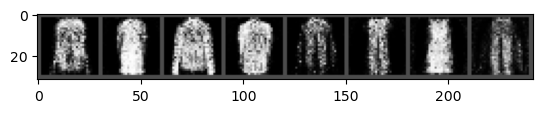

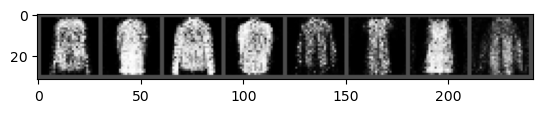

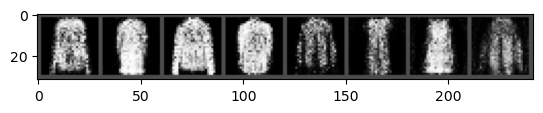

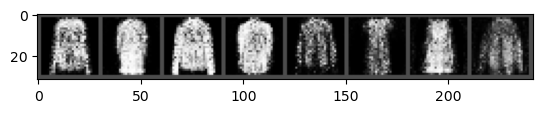

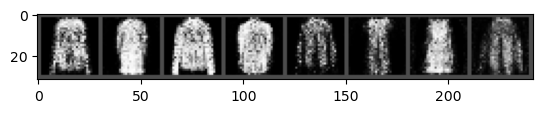

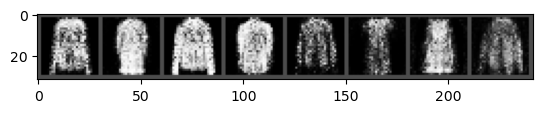

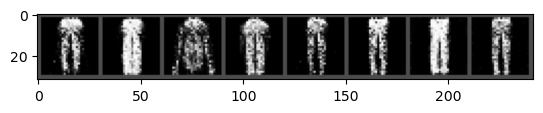

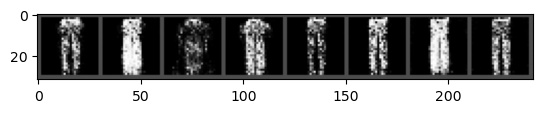

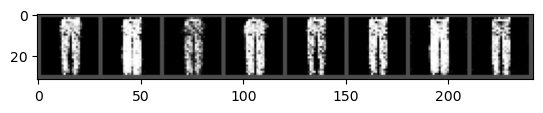

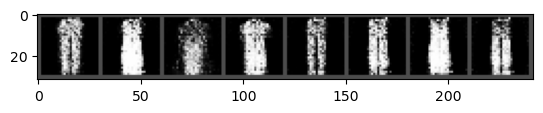

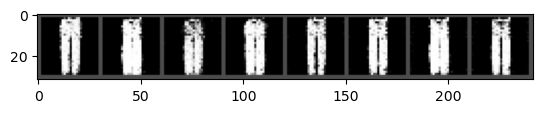

In [25]:
random_list = [0.1,1,-5]
for cnt in range(3):
    for random_num in range(5):
        for _ in random_noise:
            _[random_num] = random_list[cnt]
        x_gen = G(random_noise)
        show_imgs(x_gen, new_fig=True)

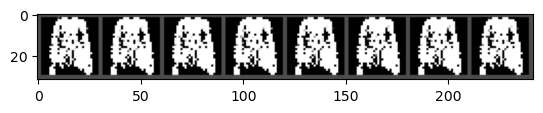

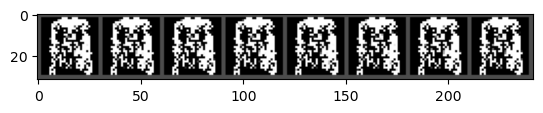

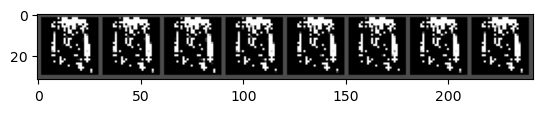

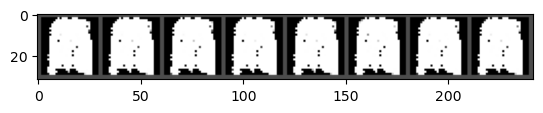

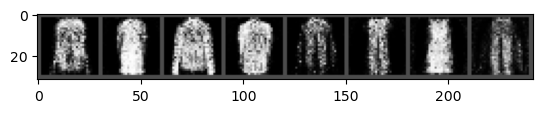

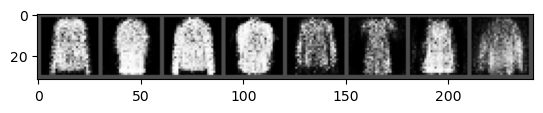

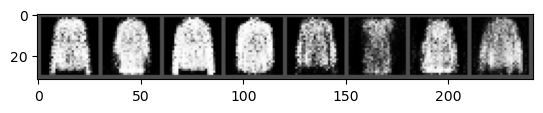

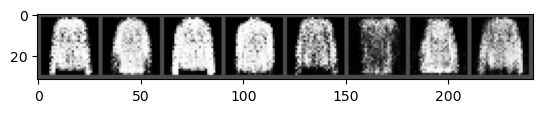

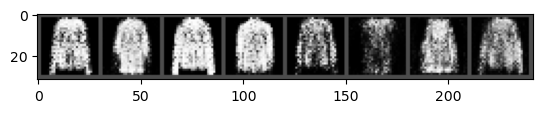

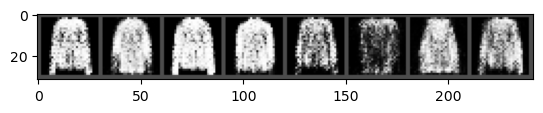

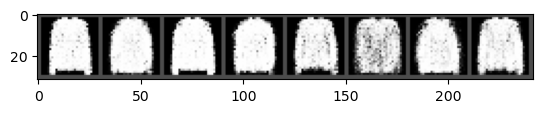

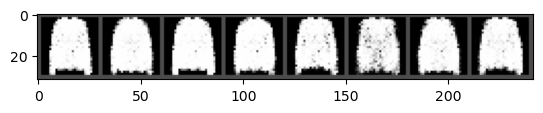

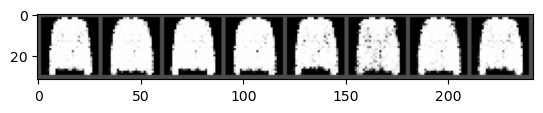

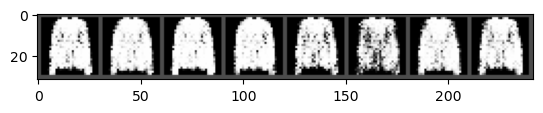

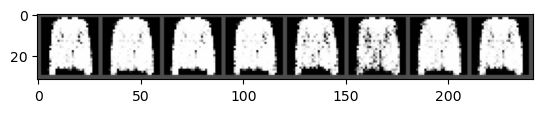

In [27]:
random_list = [0.1,3,10]
for cnt in range(3):
    for random_num in range(5):
        for _ in random_noise:
            _[random_num] = random_list[cnt]
        x_gen = G(random_noise)
        show_imgs(x_gen, new_fig=True)

In [32]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = 32 // 4
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = 32 // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [33]:
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
# parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
# parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
# parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
# parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
# parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
# parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
# parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
# parser.add_argument("--channels", type=int, default=1, help="number of image channels")
# parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
# opt = parser.parse_args()
# print(opt)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
# Re-initialize D, G:
D = Discriminator().to(device)
G = Generator().to(device)
print(D)
print(G)

Device:  cuda
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
 

In [34]:

# Now let's set up the optimizers (Adam, better than SGD for this)
optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
# optimizerD = torch.optim.Adam(D.parameters(), lr=0.001)
# optimizerG = torch.optim.Adam(G.parameters(), lr=0.001)
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)


# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, 100, device=device)
fig = plt.figure() # keep updating this one
plt.ion()

all_losses_D = []
all_losses_G = []
for epoch in range(10):  # 3 epochs
    size = 0
    current_loss = 0
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = iter(dataloader).__next__()
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)
        lossD = lossD_real + lossD_fake

        lossD.backward()
        optimizerD.step()

        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device)  # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real)  # -log D(G(z))

        lossG.backward()
        optimizerG.step()
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            # show_imgs(x_gen, new_fig=False)
            fig.canvas.draw()
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()))

    all_losses_D.append(lossD.cpu().detach().numpy())
    all_losses_G.append(lossG.cpu().detach().numpy())
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

e0.i0/938 last mb D(x)=0.4984 D(G(z))=0.4985
e0.i100/938 last mb D(x)=0.5686 D(G(z))=0.4910
e0.i200/938 last mb D(x)=0.5564 D(G(z))=0.4514
e0.i300/938 last mb D(x)=0.9482 D(G(z))=0.1327
e0.i400/938 last mb D(x)=0.9891 D(G(z))=0.0175
e0.i500/938 last mb D(x)=0.9962 D(G(z))=0.0084
e0.i600/938 last mb D(x)=0.9963 D(G(z))=0.0066
e0.i700/938 last mb D(x)=0.9968 D(G(z))=0.0053
e0.i800/938 last mb D(x)=0.9990 D(G(z))=0.0039
e0.i900/938 last mb D(x)=0.9991 D(G(z))=0.0027
e1.i0/938 last mb D(x)=0.9988 D(G(z))=0.0020
e1.i100/938 last mb D(x)=0.9983 D(G(z))=0.0024
e1.i200/938 last mb D(x)=0.9989 D(G(z))=0.0012
e1.i300/938 last mb D(x)=0.9987 D(G(z))=0.0017
e1.i400/938 last mb D(x)=0.9993 D(G(z))=0.0011
e1.i500/938 last mb D(x)=0.9995 D(G(z))=0.0010
e1.i600/938 last mb D(x)=0.9996 D(G(z))=0.0010
e1.i700/938 last mb D(x)=0.9992 D(G(z))=0.0011
e1.i800/938 last mb D(x)=0.9989 D(G(z))=0.0007
e1.i900/938 last mb D(x)=0.9991 D(G(z))=0.0006
e2.i0/938 last mb D(x)=0.9996 D(G(z))=0.0008
e2.i100/938 last mb

<Figure size 640x480 with 0 Axes>

In [47]:
import numpy as np
from torch.autograd import Variable
adversarial_loss = torch.nn.BCELoss()
cuda = True if torch.cuda.is_available() else False
if cuda:
    G.cuda()
    D.cuda()
    adversarial_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.01, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.01, betas=(0.5, 0.999))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
for epoch in range(5):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0],100))))

        # Generate a batch of images
        gen_imgs = G(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(D(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(D(real_imgs), valid)
        fake_loss = adversarial_loss(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if i%100==0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, 5, i, len(dataloader), d_loss.item(), g_loss.item())
            )

[Epoch 0/5] [Batch 0/938] [D loss: 0.000001] [G loss: 23.814491]
[Epoch 0/5] [Batch 100/938] [D loss: 0.000669] [G loss: 22.193153]
[Epoch 0/5] [Batch 200/938] [D loss: 0.000221] [G loss: 18.837584]
[Epoch 0/5] [Batch 300/938] [D loss: 0.000019] [G loss: 20.124720]
[Epoch 0/5] [Batch 400/938] [D loss: 0.000005] [G loss: 20.705032]
[Epoch 0/5] [Batch 500/938] [D loss: 0.000006] [G loss: 19.987476]
[Epoch 0/5] [Batch 600/938] [D loss: 0.000002] [G loss: 20.528458]
[Epoch 0/5] [Batch 700/938] [D loss: 0.000004] [G loss: 20.164467]
[Epoch 0/5] [Batch 800/938] [D loss: 0.000001] [G loss: 19.634966]
[Epoch 0/5] [Batch 900/938] [D loss: 0.000003] [G loss: 20.612356]
[Epoch 1/5] [Batch 0/938] [D loss: 0.000001] [G loss: 20.362537]
[Epoch 1/5] [Batch 100/938] [D loss: 0.000002] [G loss: 22.255890]
[Epoch 1/5] [Batch 200/938] [D loss: 0.000001] [G loss: 21.349216]
[Epoch 1/5] [Batch 300/938] [D loss: 0.000001] [G loss: 22.707354]
[Epoch 1/5] [Batch 400/938] [D loss: 0.000001] [G loss: 22.618919]

In [35]:
plt.figure(figsize=(5, 3))
plt.plot(all_losses_G)
plt.savefig('lossG')

plt.figure(figsize=(5, 3))
plt.plot(all_losses_D)
plt.savefig('lossV')

Error in callback <function flush_figures at 0x78e6bd30c790> (for post_execute):


KeyboardInterrupt: 

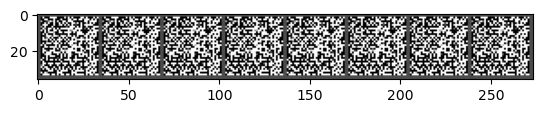

In [48]:
random_noise = torch.randn(8, 100, device=device)
x_gen = G(random_noise)
show_imgs(x_gen, new_fig=False)